In [300]:
import random
from random import randint, shuffle
import matplotlib.pyplot as plt
import numpy as np
import math

In [318]:
class Clause:                    
    def __init__(self, elems, weight):
        self._elems = elems        #the elements in a clause
        self._weight = weight      #the weight for each clause
    def evaluate (self,variables):
        res = 1
        
        n = len(self._elems)
        
        for i in range(0,n):
            x = abs(self._elems[i]) - 1   # <0 => not; >0 => normal; we start from 1 / -1 (for clause 0)
            if self._elems[i] < 0 :
                res *= (1 - variables[x])
            else:
                res *= variables[x]
        return res * self._weight
    def getWeight(self):
        return self._weight

In [319]:
class Organism:
    def __init__(self, genome, env, prob):     #env = environment = list of clauses
        self._genome = genome
        self._env = env
        self._fitness = self._computeFitness()
        self._prob = prob
    
    def _computeFitness(self):
        solvedClauses = 0
        clauseNum = len(self._env)
        for clause in self._env :
            solvedClauses += clause.evaluate(self._genome)
        return solvedClauses + 1         #fitness >= 1
    
    def mutate(self):                        #triggers a mutation cycle where each gene can change with probability prob
        varNum = len(self._genome)
        for i in range(0, varNum) :
            doMutation = np.random.binomial(1, probability, 1)
            if doMutation == 1:
                self._genome[i] = 1 - self._genome[i]
        self._fitness = self._computeFitness()
        
    def offsprings(self, totalFitness, orgNum):                    #returns a list of offsprings based on the current fitness
        offsprings = []
        myFitness = self._fitness               
        s = int(np.random.poisson(myFitness * orgNum / totalFitness, 1))   #draw a sample from Poisson distribution
        for i in range (0, s):                                  # we must have at most n children, so we integrate this directly in the sampling
            offsprings.append(Organism(self._genome.copy(), self._env, self._prob))
        return offsprings
    
    def getFitness(self):
        return self._fitness
    
    def getGenome(self):
        return self._genome.copy()
    
    def computeMutants(self) :   #returns a list of all the possible mutants of an organism at Hamming distance 1
        res = []
        l = len(self._genome)
        for i in range (0, l) :
            newGenome = self._genome.copy()
            newGenome[i] = 1 - newGenome[i]
            res.append(Organism(newGenome, self._env, self._prob))
        return res

In [329]:
class LocalStatistics:     #computes local optimality statistics, regarding the fittest closest mutant
    def __init__(self, population, maxPossibleFitness) :
        self._population = population
        self._maxFitList = []      #fitness of the fittest mutant after each round
        self._avgMutList = []      #average fitness of the possible mutants per round
        self._avgFitterList = []   #average fitness of the possible mutants that have higher fitness per round
        self._maxPossibleFitness = maxPossibleFitness   #used to normalize fitness before plotting
        
    def updateStats(self) :
        rnd = self._population.getRound()
        (maxFit, avgMut, avgFitter) = self._computeStats()
        self._maxFitList.append((rnd, maxFit / self._maxPossibleFitness))
        self._avgMutList.append((rnd, avgMut / self._maxPossibleFitness))
        self._avgFitterList.append((rnd, avgFitter / self._maxPossibleFitness))
        
    def plotStats(self):     #plot all the stats so far; each stat can also be plotted separately
        plt.title("Local statistics")
        plt.xlabel("Rounds")
        plt.ylabel("Fitness")
        self.plotMaxFit()
        self.plotAvgMut()
        self.plotAvgFitter()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
        
    def plotMaxFit(self):
        self._plotStat(self._maxFitList, "Fittest possible mutant")
        
    def plotAvgMut(self):
        self._plotStat(self._avgMutList, "Average of possible mutants")
        
    def plotAvgFitter(self):
        self._plotStat(self._avgFitterList, "Average of possible mutants that are fitter")
        
    def _plotStat(self, statList, des):
        xs = [x[0] for x in statList]
        ys = [x[1] for x in statList]
        plt.plot(xs, ys, label = des)
        
    def _computeStats(self):
        maxFit = 0
        sAvgMut = 0
        nAvgMut = 0
        sAvgFitter = 0
        nAvgFitter = 0
        for org in self._population.getOrganisms():
            mutants = org.computeMutants()
            for x in mutants:
                fit = x.getFitness()
                if fit > maxFit:
                    maxFit = fit
                sAvgMut += fit
                nAvgMut += 1
                if fit > org.getFitness():    #fitter than its parent
                    sAvgFitter += fit
                    nAvgFitter += 1
        if nAvgFitter == 0:
            nAvgFitter = 1
        return (maxFit, sAvgMut / nAvgMut, sAvgFitter / nAvgFitter)

In [330]:
class Statistics:                       #contains all the statistics and methods to update and plot them for a population
    def __init__(self, population, maxPossibleFitness) :
        self._population = population
        self._avgFitList = []
        self._maxFitList = []
        self._minFitList = []
        self._max5PerFitList = []
        self._min5PerFitList = []
        self._maxPossibleFitness = maxPossibleFitness   #used to normalize fitness before plotting
        
    def updateStats(self):
        rnd = self._population.getRound()
        self._avgFitList.append((rnd, self._computeAvgFit() / self._maxPossibleFitness))
        self._maxFitList.append((rnd, self._computeMaxFit() / self._maxPossibleFitness))
        self._minFitList.append((rnd, self._computeMinFit() / self._maxPossibleFitness))
        self._max5PerFitList.append((rnd, self._computeMax5PerFit() / self._maxPossibleFitness))
        self._min5PerFitList.append((rnd, self._computeMin5PerFit() / self._maxPossibleFitness))
        
    def plotStats(self):     #plot all the stats so far; each stat can also be plotted separately
        plt.title("General statistics")
        plt.xlabel("Rounds")
        plt.ylabel("Fitness")
        self.plotAvgFit()
        self.plotMinFit()
        self.plotMaxFit()
        self.plotMin5PerFit()
        self.plotMax5PerFit()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()
        
    def plotMax5PerFit(self):
        self._plotStat(self._max5PerFitList, "Maximum 5% average")
        
    def plotMin5PerFit(self):
        self._plotStat(self._min5PerFitList, "Minimum 5% average")
    
    def plotAvgFit(self):
        self._plotStat(self._avgFitList, "Average")
    
    def plotMaxFit(self):
        self._plotStat(self._maxFitList, "Maximum")
        
    def plotMinFit(self):
        self._plotStat(self._minFitList, "Minimum")
    
    def _plotStat(self, statList, des):
        xs = [x[0] for x in statList]
        ys = [x[1] for x in statList]
        plt.plot(xs,ys, label = des)
        
    def _computeAvgFit(self):
        s = 0
        orgs = self._population.getOrganisms()
        for i in range(0, orgNum):
            s += orgs[i].getFitness()
        return s / orgNum
        
    def _computeMaxFit(self):
        maxFit = 0
        orgs = self._population.getOrganisms()
        for i in range(0, orgNum):
            fit = orgs[i].getFitness()
            if fit > maxFit:
                maxFit = fit
        return maxFit
    
    def _computeMinFit(self):
        minFit = 1000000000
        orgs = self._population.getOrganisms()
        for i in range(0, orgNum):
            fit = orgs[i].getFitness()
            if fit < minFit:
                minFit = fit
        return minFit
    
    def _computeMin5PerFit(self):
        orgs = self._population.getOrganisms()
        fit = []
        for i in range(0, orgNum):
            fit.append(orgs[i].getFitness())
        fit.sort()
        l = int(math.ceil(len(fit) * 0.05))      #get only the first 5%
        fit = fit[:l]
        s = 0
        for x in fit:                            #compute the average of it
            s += x
        return s / l
    
    def _computeMax5PerFit(self):
        orgs = self._population.getOrganisms()
        fit = []
        for i in range(0, orgNum):
            fit.append(orgs[i].getFitness())
        fit.sort(reverse = True)
        l = int(math.ceil(len(fit) * 0.05))      #get only the first 5% (biggest 5%)
        fit = fit[:l]
        s = 0
        for x in fit:                            #compute the average of it
            s += x
        return s / l
    
    def plotGenome(self):
        orgs = self._population.getOrganisms()
        for org in orgs:
            print(str(org.getFitness()) + "   " + str(org.getGenome()))
        
    

In [331]:
class Population:                        #contains the current population and statistics; is updated on nextGeneration call
    def __init__(self, orgNum, env, prob, initial):
        self._orgNum = orgNum
        self._env = env
        self._prob = prob
        self._organisms = []
        self._round = 0
        self._maxPossibleFitness = 0    #used to normalize fitness when plotting
        
        for x in env:
            self._maxPossibleFitness += x.getWeight()

        self._stats = Statistics(self, self._maxPossibleFitness)
        self._localStats = LocalStatistics(self, self._maxPossibleFitness)    

        for i in range(0, orgNum):
            self._organisms.append(Organism(initial, self._env, self._prob))
        self._stats.updateStats()
        self._localStats.updateStats()

    def getOrganisms(self) :
        return self._organisms.copy()
    
    def getRound(self) :
        return self._round
    
    def getStats(self) :
        return self._stats
    
    def getLocalStats(self) :
        return self._localStats
    
    def nextGeneration(self):
        nextGenPool = []
        self._round += 1
        totalFitness = 0                                        #compute total fitness for offspring generation
        for i in range(0, orgNum):
            self._organisms[i].mutate()                          #generate mutations
            totalFitness += self._organisms[i].getFitness()
        for i in range(0, orgNum):
            nextGenPool += self. _organisms[i].offsprings(totalFitness, orgNum)       #compute the next generation pool
        shuffle(nextGenPool)                               #shuffle the pool
        newLen = len(nextGenPool)
        if newLen < orgNum :
            shuffle(self._organisms)
            nextGenPool += self._organisms[:(orgNum - newLen)]   #if we don't have enough offsprings, recycle some old ones
        self._organisms = nextGenPool[:orgNum]                   #get only the first lorgNum from it; others are discarded
        self._stats.updateStats()                                      #update the stats for the new generation
        self._localStats.updateStats()
            

In [332]:
class Simulator:  
    def __init__(self, 
                initial,         #the initial values given to each variable / initial genome
                probability,     #the probability of a mutation
                rounds,          #the number of rounds to be considered
                orgNum,          #the number of organisms
                clauses):        #the list of clauses
        self._initial = initial
        self._probability = probability
        self._rounds = rounds
        self._orgNum = orgNum
        self._clauses = clauses
        self._population = Population(self._orgNum, self._clauses, self._probability, self._initial)
    
    def run(self):
        for i in range (0, rounds):
            self._population.nextGeneration()
        self._population.getStats().plotStats()
        self._population.getLocalStats().plotStats()

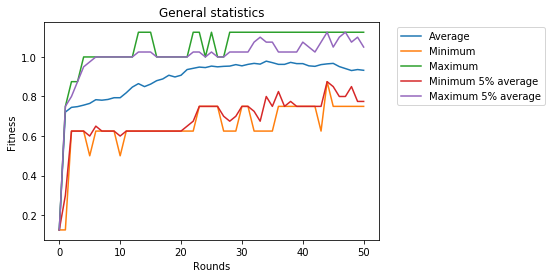

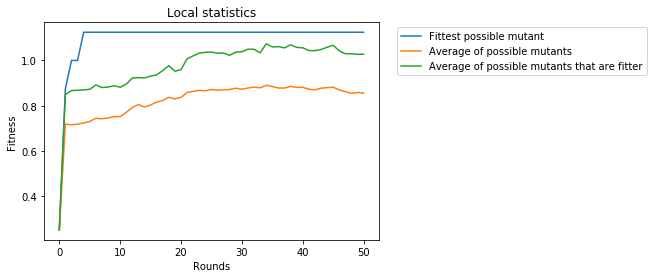

In [333]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.01
rounds = 50
orgNum = 100
clause1 = Clause([1],1)
clause2 = Clause([2],1)
clause3 = Clause([3],1)
clause4 = Clause([4],1)
clause5 = Clause([5],1)
clause6 = Clause([6],1)
clause7 = Clause([7],1)
clause8 = Clause([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

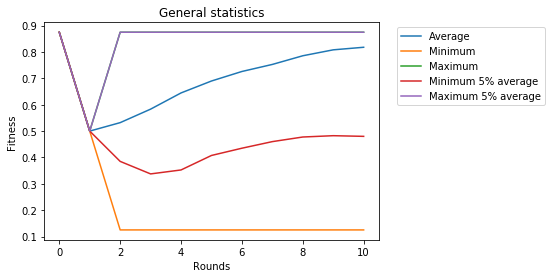

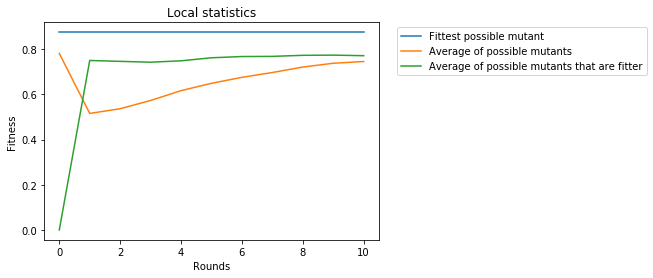

In [334]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.05
rounds = 10
orgNum = 1000
clause1 = Clause([1,2,3],1)
clause2 = Clause([5,4,7],1)
clause3 = Clause([-3],3)
clause4 = Clause([-4],3)
clauses = [clause1, clause2, clause3, clause4]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

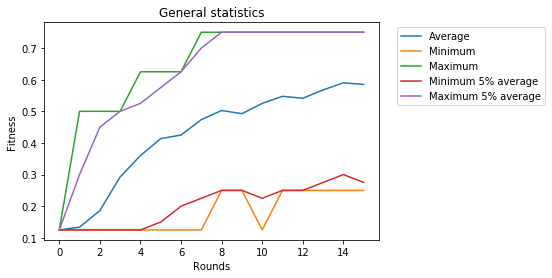

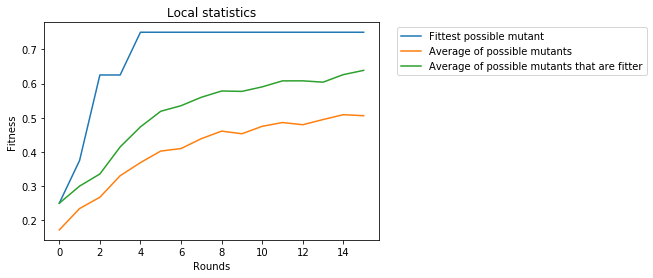

In [335]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.05
rounds = 15
orgNum = 100
clause1 = Clause([1,2,3],1)
clause2 = Clause([5,-4,7],1)
clause3 = Clause([6,7],1)
clause4 = Clause([1,-2],1)
clause5 = Clause([5,8],1)
clause6 = Clause([6,-8],1)
clause7 = Clause([7,-3],1)
clause8 = Clause([8,3],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

In [ ]:
#Observations:
#    Under this model, they tend to converge to an optimum quite fast
    
#What to do:
#    How to select the children / try various methods
#    For local statistics, how to plot the individuals
#    Use joyplots

[3]
